<a href="https://colab.research.google.com/github/Computerglassformedandsurg/SAM_based_ASTM_Grain_Size_Analysis/blob/main/373_SAM_based_ASTM_Grain_Size_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmenteverygrain rtree # rtree is for spatial indexing

Caution: Sometime the image can be with one channel


## Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download Unet model - Already downloaded (mount the drive)

In [ ]:
# import os

# # 1. Create the full directory path (this handles the space correctly)
# target_dir = "/content/drive/MyDrive/Segmentation Projects/grainsegmentation/"
# os.makedirs(target_dir, exist_ok=True)

# # 2. Move and rename the incorrectly named file to the right spot
# # In your log, it was saved as '/content/drive/MyDrive/Segmentation'
# !mv "/content/drive/MyDrive/Segmentation" "/content/drive/MyDrive/Segmentation Projects/grainsegmentation/seg_model.keras"

# print("Done! Checking the file location...")
# !ls -lh "/content/drive/MyDrive/Segmentation Projects/grainsegmentation/"

Done! Checking the file location...
total 25M
-rw------- 1 root root 25M Dec 18 03:05 seg_model.keras


## Download SAM models - Already downloaded (mount the drive)


In [ ]:
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O "/content/drive/MyDrive/Segmentation Projects/grainsegmentation/sam_vit_b_01ec64.pth"


## Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from PIL import Image
from scipy import ndimage
from skimage import measure
import os
from pathlib import Path

import segmenteverygrain as seg
from keras.utils import load_img
from segment_anything import sam_model_registry, SamPredictor
from tqdm import tqdm

Model_Paths = {
    'unet': "/content/drive/MyDrive/Segmentation Projects/grainsegmentation/seg_model.keras",
    'sam': "/content/drive/MyDrive/Segmentation Projects/grainsegmentation/sam_vit_b_01ec64.pth"

}

In [ ]:
Img_path = "/content/drive/MyDrive/Segmentation Projects/grainsegmentation/Microstructure.jpg"
output_path = "/content/drive/MyDrive/Segmentation Projects/grainsegmentation/Results"

Scale_um_per_pixel = 0.25 # adjust based on the microscope settings
Min_grain_area = 100 #minimum grain area in pixels

## Image Loading and preprocessing

### Function to convert from RGB to Grayscale

In [ ]:
# function to convert RGB to grayscale
def convert_rgb_to_gray(image):
  """
  Simply converting rgb to gray
  converts 3 dimensional image using the formula
  if the image is gray or one dimension then it returns the first channel itself

  Standard RGB (3 channels): It applies the math and flattens the 3 layers into 1.

  Single-channel images (Shape (H, W, 1)): It just "squeezes" the extra dimension to give you a 2D array.

  Already Grayscale (2D array): It returns the image exactly as it is.
  """
  if len(image.shape) == 2: # if the image is 2D, then return it
    return image

  if len(image.shape) == 3: # if it is 3D (H, W, C)
    # Check if it has 3 channels
    if image.shape[2] == 3:
      gray = 0.299 * image[:,:,0] + 0.587 * image[:,:,1] + 0.114 * image[:,:,2]
      return gray.astype(np.uint8)
    else:
    # If it's (H, W, 1), just return the 2D slice
      return image[:,:,0]
  return image

In [ ]:
# Load the microstructure image
original_image = np.array(load_img(Img_path))

# Convert to grayscale for analysis
if len(original_image.shape) == 3:
  gray_image = convert_rgb_to_gray(original_image)
else:
  gray_image = original_image


## Display the loaded image

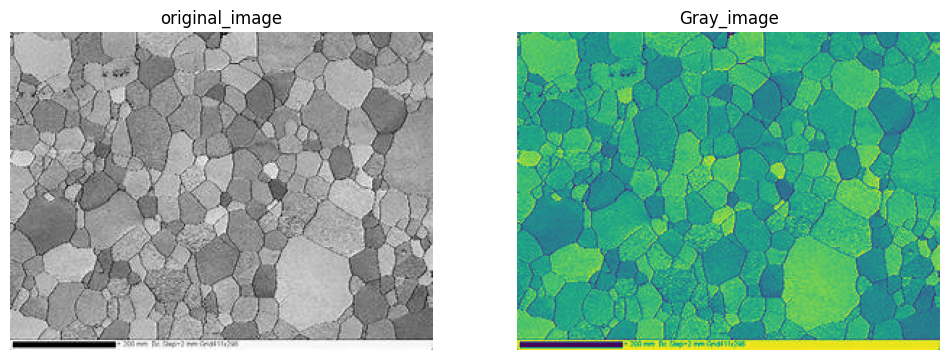

In [ ]:
plt.figure(figsize = (12,5))
if len(original_image.shape) == 3:
  plt.subplot(1, 2, 1)
  plt.imshow(original_image)
  plt.title("original_image")
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(gray_image)
  plt.title("Gray_image")
  plt.axis('off')

else:
  plt.imshow(original_image, cmap = 'gray')
  plt.title("Original image")
  plt.axis('off')



## UNET Grain Detection

In [ ]:
# Load the unet model
# not using the standard cross-entropy model but weighted cross entropy

# why weighted cross entropy - gives importance to grain_image segmentation
# if the segmentation misses one grain pixel it is 100 times painful than missing background pixel

try:
  unet_model = seg.load_model(
      Model_Paths['unet'],
      custom_objects = {'weighted_crossentropy' : seg.weighted_crossentropy}
  )
  print("Unet model is loaded successfully")
except Exception as e:
  print(f"Error loading U-Net model: {e}")
  raise

Unet model is loaded successfully


## Unet Prediction

In [ ]:
img_pred = seg.predict_image(original_image, unet_model, I=256)
print(f"U-net segmented image.shape: {img_pred.shape}")

segmenting image tiles...


100%|██████████| 2/2 [00:00<00:00, 24105.20it/s]


U-net segmented image.shape: (220, 292, 3)


## Extract Grain ingredients

In [ ]:
#If two "potential" grain points are closer than this distance - 6.0, the code treats them as the same grain.
# if the centroids are more than 0.6 apart, it will be two different region
# The seg.label_grains function takes the general segmentation from the U-Net (which might just be a binary image of 'grain' vs 'not grain') and
# then processes it to assign a unique individual ID to each distinct grain.
# This allows you to treat each grain as a separate entity for further analysis, like measuring its area or shape.
# labels_unet is the image with label and coords are the centroid of the each grain
labels_unet, coords = seg.label_grains(original_image, img_pred, dbs_max_dist = 0.6)
No_of_labels = len(coords)
print(f"Found {No_of_labels} labels")

Found 311 labels


## Visualize the Unet results

(np.float64(-0.5), np.float64(291.5), np.float64(219.5), np.float64(-0.5))

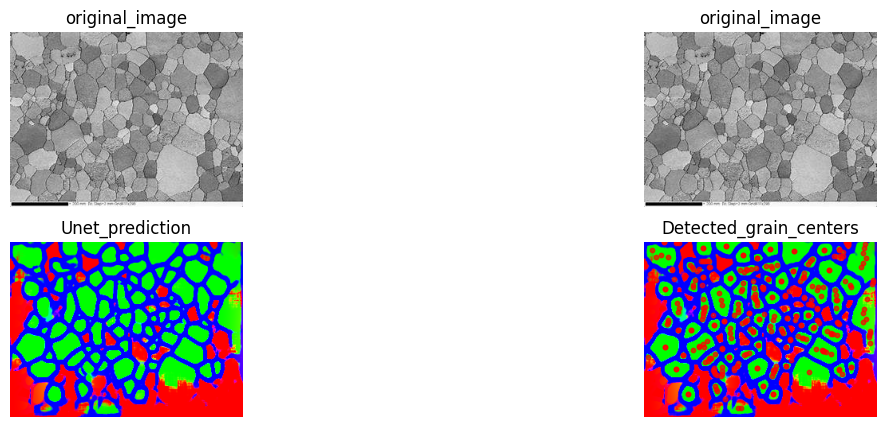

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(2, 2, 1)
plt.imshow(original_image)
plt.title("original_image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(gray_image, cmap='gray')
plt.title("original_image")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(img_pred, cmap='hot')
plt.title("Unet_prediction")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(img_pred, cmap='gray')
if No_of_labels > 0:
  coords_array  = np.array(coords)
  plt.scatter(coords_array[:,0], coords_array[:,1], c='red',s=10, alpha=0.7)
plt.title("Detected_grain_centers")
plt.axis("off")

## SAM Segmentation Refinement

In [ ]:
def sam_seg(sam_model, image, coords, min_area=50):
  """
  return masks

  """
  predictor = SamPredictor(sam_model)
  predictor.set_image(image)

  all_masks = []
  all_scores = []
  successful_coords = []

  batch_size = 50 # processing in bathces in GPU

  for batch_start in range(0, len(coords), batch_size):
      batch_end = min(batch_start + batch_size, len(coords))
      batch_coords = coords[batch_start:batch_end]

      # Handles if the input is in array, tuples and list - shout out to Digital sreeni youtube channel
      # tqdm to print the progess
      # this for loop goes by batch by batch
      for i, coords in enumerate(tqdm(batch_coords, desc=f"SAM batch {batch_start//batch_size + 1}" )):
        try:
            # isinstance(object, type): This checks if a variable belongs to a specific class (like a NumPy array or a List)
            if isinstance(coords, np.ndarray):
              x, y = int(coords[0]), int(coords[1])
            elif isinstance(coords, (list, tuple)) and len(coords) == 2:
              x, y = int(coords[0]), int(coords[1])
            else:
              continue
              # can fix here to skip to loop

            # if the coordinates are out of bounds, the following code line helps
            if x < 0 or x >= image.shape[1] or y < 0 or y >= image.shape[0]:
              continue
              # can fix here to skip to loop

            point_coords = np.array([[x, y]])
            point_labels = np.array([1])

            # masks gives 3D images with the first dimension as the number of masks - [no.of masks, height, width]
            # scores give out the confidential score
            # logits is merely the raw outputs, the numerical results produced by neural network's final layer

            masks, scores, logits = predictor.predict(
                point_coords=point_coords,
                point_labels=point_labels,
                multimask_output=True
            )

            # Take the best mask
            # min_area - for area filtering
            if len(masks) > 0 and len(scores) > 0:
              # out of three guesses SAM made, this picks one with the highest confidential score
              # np.argmax() gives out the index of the max value
              best_idx = np.argmax(scores)
              mask = masks[best_idx]
              score = scores[best_idx]

              if mask is not None and np.sum(mask) >=min_area:
                all_masks.append(mask)
                all_scores.append(scores)
                # The successful_coords list contains the [x, y] centroids of only those masks that were successfully generated by SAM and also met the min_area requirement.
                # This ensures that you're only tracking meaningful grain segmentations, not tiny, potentially erroneous ones.
                successful_coords.append([x, y])
        except Exception as e:
          continue
  return all_masks, all_scores, successful_coords



## Load SAM model with GPU

In [ ]:

try:
  import torch
  if torch.cuda.is_available():
    device = "cuda"
    print(f"GPU is detected: {torch.cuda.get_device_name(0)}")
    #used to convert the raw memory size of your GPU from Bytes into Gigabytes
    print(f"Gpu has memory of about {torch.cuda.get_device_properties(0).total_memory/ 1024**3:.1f} GB")
  else:
    device = "cpu"
    print("No GPU has been detected, hence using CPU")

  # Loading the visual transformer
  sam_model = sam_model_registry["vit_b"](checkpoint = Model_Paths['sam'])
  sam_model.to(device=device)
  print(f"SAM model loaded sucessfully on {device}")

  # printing the memory allocation within GPU cuda
  if device =="cuda":
    print(f"GPU memory allocated: {torch.cuda.memory_allocated(0)/1024**3:.2f}GB")

except Exception as e:
  print(f"Error loading SAM model: {e}")
  raise


GPU is detected: Tesla T4
Gpu has memory of about 14.7 GB
SAM model loaded sucessfully on cuda
GPU memory allocated: 0.35GB


## Execute SAM segmentation

In [ ]:
if len(coords)>0:
  # SAM is designed for color images. One can input the gray image, but color image does have more information
  # SAM uses original image as canvas, to understand the full context and coords acts as prompts so SAM need not look for objects
  # SAM predicts the entire object as mask based on not only on the intensity of pixels as in region growing ..
  # ..but based on the vast amount of visual knowledge learned during training
  masks, scores, successful_coords = sam_seg(sam_model, original_image, coords, min_area=Min_grain_area
                                            )
  print(f"SAM generated {len(masks)} valid masks from {len(coords)} attempts")

else:
  masks, scores, successful_coords = [],[],[]
  print("No coordinates available for SAM masks")


SAM batch 1: 100%|██████████| 50/50 [00:00<00:00, 68.55it/s]
SAM batch 2: 0it [00:00, ?it/s]
SAM batch 3: 0it [00:00, ?it/s]
SAM batch 4: 0it [00:00, ?it/s]
SAM batch 5: 0it [00:00, ?it/s]
SAM batch 6: 0it [00:00, ?it/s]
SAM batch 7: 0it [00:00, ?it/s]

SAM generated 47 valid masks from 311 attempts


## Create labeled image from the masks

In [ ]:
original_image = np.array(load_img(Img_path))

print(original_image.shape)


(220, 292, 3)


In [ ]:
# function to created labeled image from the sam masks

def create_labeled_img_from_sam_masks(masks, image_shape):
  """Create 2D labeled image from SAM masks"""
  # check if the image is 3 channels
  if len(image_shape) == 3:
    labels = np.zeros(image_shape[:2], dtype=np.int32) # create an empty 2D image image
    # if the shape of the image shape is w x h x , image_shape[:2] will be of the shape of w x h
  else:
    labels = np.zeros(image_shape, dtype=np.int32)

  for i, mask in enumerate(masks):
    if len(mask.shape) == 3:
      # double checking if the mask is 2D. Sometimes it will have a third dimension which is simply 1 instead of 2D image
      # if it has a third dimension that is 2d, we perform any, (OR) operation across the 2D channel
      # that is if the third dimension is more than 1 combine them as one 2D image
      mask = mask[:, :, 0] if mask.shape[2] == 1 else np.any(mask, axis=2)
    # To avoid overlapping
    # remember initially the label image is array of zeros
    # It only considers pixels that are part of the current segment (mask).
    # It only applies the new label to those pixels that haven't been claimed by a previous segment (labels==0)
    # if both the condition is fulfilled, then we assign the label values
    labels[mask & (labels==0)] = i + 1

  return labels


if len(masks) > 0:
  sam_labels = create_labeled_img_from_sam_masks(masks, original_image.shape)


In [ ]:
import numpy as np

# Example 1: Basic usage with a 1D array
bool_array_1d = np.array([False, False, True, False])
result_1 = np.any(bool_array_1d)
print(f"Example 1 (1D array): {bool_array_1d}\nResult: {result_1}\n")

# Example 2: No True values
bool_array_no_true = np.array([False, False, False])
result_2 = np.any(bool_array_no_true)
print(f"Example 2 (No True values): {bool_array_no_true}\nResult: {result_2}\n")

# Example 3: Usage with a 2D array without specifying axis
bool_array_2d = np.array([
    [False, False, True],
    [False, False, False]
])
result_3 = np.any(bool_array_2d)
print(f"Example 3 (2D array, no axis):\n{bool_array_2d}\nResult: {result_3}\n")

# Example 4: Usage with a 2D array, checking along axis 0 (columns)
bool_array_2d_axis0 = np.array([
    [False, True, False],
    [False, False, False]
])
result_4 = np.any(bool_array_2d_axis0, axis=0)
print(f"Example 4 (2D array, axis=0):\n{bool_array_2d_axis0}\nResult: {result_4}\n")

# Example 5: Usage with a 2D array, checking along axis 1 (rows)
bool_array_2d_axis1 = np.array([
    [False, False, False],
    [False, True, False]
])
result_5 = np.any(bool_array_2d_axis1, axis=1)
print(f"Example 5 (2D array, axis=1):\n{bool_array_2d_axis1}\nResult: {result_5}\n")

# Example 6: Simulating a 3D mask with np.any(axis=2)
# Imagine a mask of shape (height, width, channels)
# where each channel is a boolean mask for something specific.
# We want to know if *any* channel is True at a given (height, width) pixel.
multi_channel_mask = np.array([
    [[False, False], [True, False]],
    [[False, False], [False, True]]
]) # Shape (2, 2, 2) - 2x2 image, 2 channels

print(f"Example 6 (3D array, axis=2):\n{multi_channel_mask}\n")
print(f"Shape before np.any(axis=2): {multi_channel_mask.shape}\n")

combined_2d_mask = np.any(multi_channel_mask, axis=2)
print(f"Result after np.any(axis=2):\n{combined_2d_mask}\n")
print(f"Shape after np.any(axis=2): {combined_2d_mask.shape}\n")

# In Example 6, the output 'combined_2d_mask' will be True for a pixel
# if that pixel is True in *either* of the two channels.

## Visualization of SAM results

In [ ]:
gray_image + img_pred[:,:,0]+sam_labels

array([[ 99.00000003, 113.        , 197.00000023, ..., 132.15644209,
        134.16540538, 121.17340898],
       [127.        ,  77.        , 114.00000021, ..., 113.1564472 ,
        125.16544506, 137.17399722],
       [208.        , 109.        , 100.00000002, ..., 117.15647738,
        127.16552711, 132.1741446 ],
       ...,
       [248.20357553, 194.2032102 ,   4.20247905, ..., 248.19820389,
        238.19808089, 232.19796118],
       [241.1937446 , 249.19341238, 137.19267715, ..., 256.18841691,
        256.18829484, 228.18817611],
       [185.18409956, 256.18376999, 239.18369433, ..., 254.17881473,
        239.17869384, 162.17857607]])

Text(0.5, 1.0, 'Unet predictions and SAM predictions overlayed on the original image')

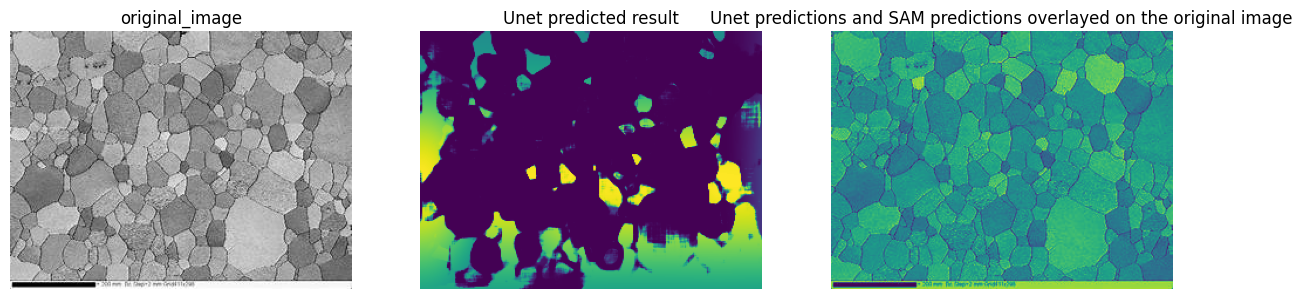

In [ ]:
plt.figure(figsize=(15,10))

 # original image - inputs
plt.subplot(2,3,1)
plt.imshow(gray_image, cmap='gray')
plt.title("original_image")
plt.axis('off')

# Unet Grain prediction
plt.subplot(2,3,2)
plt.imshow(img_pred[:,:,0])
plt.title("Unet predicted result")
plt.axis("off")

# SAM results -Output
plt.subplot(2,3,3)
plt.imshow(sam_labels)
plt.title("Sam result")
plt.axis("off")

# It overlays the Unet generated grains and SAM masks on the top of the original image - final result
plt.subplot(2,3,3)
overlayed_image = gray_image + img_pred[:,:,0]+sam_labels
plt.imshow(overlayed_image)
plt.title("Unet predictions and SAM predictions overlayed on the original image")

# Measurement Science - SAM Grain Size Distribution - measurement


# SAM Quality vs Grain size - Reliability

## s

Ref - https://www.youtube.com/watch?v=KCGKLh05HRM